In [1]:
#Get file data and organize into list 
import json

stock_id = [str(st) for st in range(1101, 10000)]
id_index = []
price_list = []
yield_list = []
pe_list = []

#Get the latest data
def get_data(rows, name):
    num = -1
    while True:
        if rows[num][name] == None:
            num -= 1
        else:
            return rows[num][name]
        if num < -10:
            return None

#Organize the values for analysis in each stock to lists
for sid in stock_id:
    try:
        op = open('D:/StockData/ForAnalysis/'+sid+'.json', 'r', encoding='utf-8')
    except:
        continue
    rows = json.loads(op.read())
    op.close()
    price = get_data(rows, '收盤價')
    yield_rate = get_data(rows, '殖利率')
    pe = get_data(rows, '本益比')
    id_index.append(sid)
    price_list.append(price)
    yield_list.append(yield_rate)
    pe_list.append(pe)


print(len(id_index))
print(len(price_list))
print(len(yield_list))
print(len(pe_list))

622
622
622
622


In [2]:
#Get file data and organize into list
stock_id = ['TAIEX']
taiex_price = []

for sid in stock_id:
    try:
        op = open('D:/StockData/ForAnalysis/'+sid+'.json', 'r', encoding='utf-8')
    except:
        continue
    rows = json.loads(op.read())
    op.close()
    for row in rows:
        taiex_price.append(row[4])
del taiex_price[0]
print('done')

done


In [3]:
#Get file data and organize into list
all_stock_price = [[] for n in range(len(id_index))]
date_list = []
for idx in range(len(id_index)):
    op = open('D:/StockData/ForAnalysis/'+id_index[idx]+'.json', 'r', encoding='utf-8')
    rows = json.loads(op.read())
    op.close()
    for row in rows:
        all_stock_price[idx].append(row['收盤價'])

op = open('D:/StockData/ForAnalysis/1101.json', 'r', encoding='utf-8')
rows = json.loads(op.read())
op.close()
for row in rows:
    date_list.append(row['日期'])
print('done')

done


In [332]:
#各股股價與台指相關性 240日
#Correlation between 240 days stock prices and Taiwan Stock Price Index
import numpy as np
import pandas as pd

taiex_stock_correlation = []
for idx in range(len(id_index)):
    df = pd.DataFrame({'TAIEX': taiex_price[-240:-1], id_index[idx]: all_stock_price[idx][-240:-1]})
    taiex_stock_correlation.append((df.corr().loc['TAIEX'][id_index[idx]]))
print('done')

done


In [4]:
#各股股價與台指相關性 120日
#Correlation between 120 days stock prices and Taiwan Stock Price Index
import numpy as np
import pandas as pd

taiex_stock_correlation120 = []
for idx in range(len(id_index)):
    df = pd.DataFrame({'TAIEX': taiex_price[-121:-1], id_index[idx]: all_stock_price[idx][-121:-1]})
    taiex_stock_correlation120.append((df.corr().loc['TAIEX'][id_index[idx]]))
print('done')

done


In [5]:
#K-means
import math
import statistics
import numpy as np

amt = 10
items = [price_list, yield_list, pe_list, taiex_stock_correlation120]

#Randomly get the starting center position of each dimension
def get_begin_centroids(items, amt):
    centroids = [[] for n in range(len(items))]
    for dm in range(len(items)):
        for nm in range(amt):
            cen = np.random.uniform(0, max(items[dm]))
            centroids[dm].append(float('%.2f' %cen))
    return centroids

#Make clusters
def make_clusters(items, item_amount, centroids, key_amount):
    clusters = [[] for n in range(key_amount)]
    for n2 in range(item_amount):
        distance = None
        cluster_index = None
        for m in range(key_amount):
            dist_list = []
            for item, cen in zip(items, centroids):
                r = (item[n2] - cen[m])**2
                dist_list.append(r)
            dist = (sum(dist_list)) ** 0.5
            if distance == None:
                distance = dist
                cluster_index = m
            elif dist < distance:
                distance = dist
                cluster_index = m
        clusters[cluster_index].append(n2)    
    for cls in clusters.copy():
        if not len(cls):
            clusters.remove(cls)
    if not len(clusters) == key_amount:
        clusters = divid_clusters(clusters, key_amount-len(clusters)+1)
    return clusters

#Check if the calculated center is the same as the previous time
def is_final_keys(final_keys, centroids):
    for dim1, dim2 in zip(final_keys, centroids):
        result = set(dim1)^set(dim2)
        if result:
            return False
    return True

#Divid clusters
def divid_clusters(clusters, amount):
    list_num = []
    for cls in clusters:
        list_num.append(len(cls))
    dcluster = clusters.pop(list_num.index(max(list_num)))
    divid_num = int(max(list_num)/amount)
    dcls = [[] for a in range(amount)]
    for didx in range(amount):
        if didx == amount-1:
            dcls[didx] = dcluster
        for dn in range(divid_num):
            dcls[didx].append(dcluster.pop())
    for dcl in dcls:
        clusters.append(dcl)
    return clusters

#Get center of the cluster
def get_centroid(items, cluster):
    centroid = []
    distance = []
    for item in items:
        distance = []
        for cs in cluster:
            distance.append(item[cs])
        centroid.append(statistics.mean(distance))
    for cls in cluster:
        dist_list = []
        for item, cen in zip(items, centroid):
            r = (item[cls] - cen)**2
            dist_list.append(r)
        distance.append((sum(dist_list)) ** 0.5)
    return centroid, statistics.mean(distance)

#Main program of K-means
def run_k_means(items, items_amount, clusters_amount):
    begin_centroids = get_begin_centroids(items, clusters_amount)
    final_keys = begin_centroids
    times = 0
    while True:
        times += 1
        clusters = make_clusters(items, len(items[0]), final_keys, clusters_amount)
        centroids = [[] for n in range(len(final_keys))]
        total_distance = 0
        for cluster in clusters:
            cen, distance = get_centroid(items, cluster)
            total_distance += distance
            for cd, data in zip(centroids, cen):
                cd.append(data)
        if is_final_keys(final_keys, centroids):
            final_keys = centroids
            break
        final_keys = centroids
        if times > 100:
            break
    return clusters, times, total_distance/clusters_amount



clusters, times, avg_distance = run_k_means(items, len(items[0]), amt)

print('%d items %d dimensions divided into %d groups by counting %d times' %(len(items[0]), len(items), amt, times))
print('Averige Distance:', avg_distance)
print(len(clusters), 'Clusters')

622 items 4 dimensions divided into 10 groups by counting 17 times
Averige Distance: 13.218200695302656
10 Clusters


In [230]:
#Get the best K-means clusters
amt = 10
run_time = 500

result = {}
for n in range(run_time):
    clusters, times, avg_distance = run_k_means([price_list, yield_list, pe_list, taiex_stock_correlation120], len(id_index), amt)
    result[str(avg_distance)] = clusters

min_ridx = 999999999
for k in result.keys():
    if float(k) < float(min_ridx):
        min_ridx = k
best_clusters = result[min_ridx]
print('Min averige distance is', min_ridx)
n = 1
for cls in best_clusters:
    print(n, '. Cluster: ', cls)
    n += 1


Min averige distance is 9.90692072900648
1 . Cluster:  [478, 549]
2 . Cluster:  [546]
3 . Cluster:  [21, 36, 131, 228, 286, 369, 431, 442, 618, 621]
4 . Cluster:  [66, 88, 110, 183, 198, 211, 221, 226, 245, 263, 272, 313, 377, 395, 409, 416, 427, 553, 556, 579, 582, 597, 599, 602]
5 . Cluster:  [312, 428]
6 . Cluster:  [65, 97, 167, 168, 182, 185, 196, 252, 351, 405, 440, 548, 585, 587]
7 . Cluster:  [17, 22, 38, 72, 87, 92, 123, 136, 177, 184, 187, 190, 202, 213, 217, 223, 229, 232, 241, 254, 255, 275, 311, 314, 315, 354, 356, 368, 370, 384, 385, 404, 406, 411, 415, 420, 425, 438, 443, 447, 448, 456, 458, 468, 470, 476, 480, 492, 496, 515, 534, 538, 539, 540, 552, 554, 555, 557, 559, 562, 568, 600, 615]
8 . Cluster:  [5, 11, 13, 45, 56, 63, 81, 117, 121, 132, 133, 137, 139, 142, 154, 164, 165, 169, 170, 174, 191, 193, 209, 240, 270, 274, 277, 282, 293, 298, 307, 345, 348, 353, 378, 387, 389, 391, 394, 397, 401, 403, 439, 451, 454, 467, 505, 507, 510, 513, 516, 530, 533, 545, 581]
9 . 

In [6]:
#Find the best number of clusters
amt = range(3, 13)
run_time = 100

amt_result = []
for an in amt:
    result = []
    for n in range(run_time):
        clusters, times, avg_distance = run_k_means([price_list, yield_list, pe_list, taiex_stock_correlation120], len(id_index), an)
        result.append(avg_distance)
    amt_result.append(statistics.mean(result))
    print(an, 'done')

print(amt_result)

3 done
4 done
5 done
6 done
7 done
8 done
9 done
10 done
11 done
12 done
[27.88315504324353, 26.19714303579448, 24.083077571964395, 21.218596199870966, 18.985706711950925, 16.844508106091418, 15.570159849112699, 13.566781001334007, 12.535516515752061, 11.60627408475043]


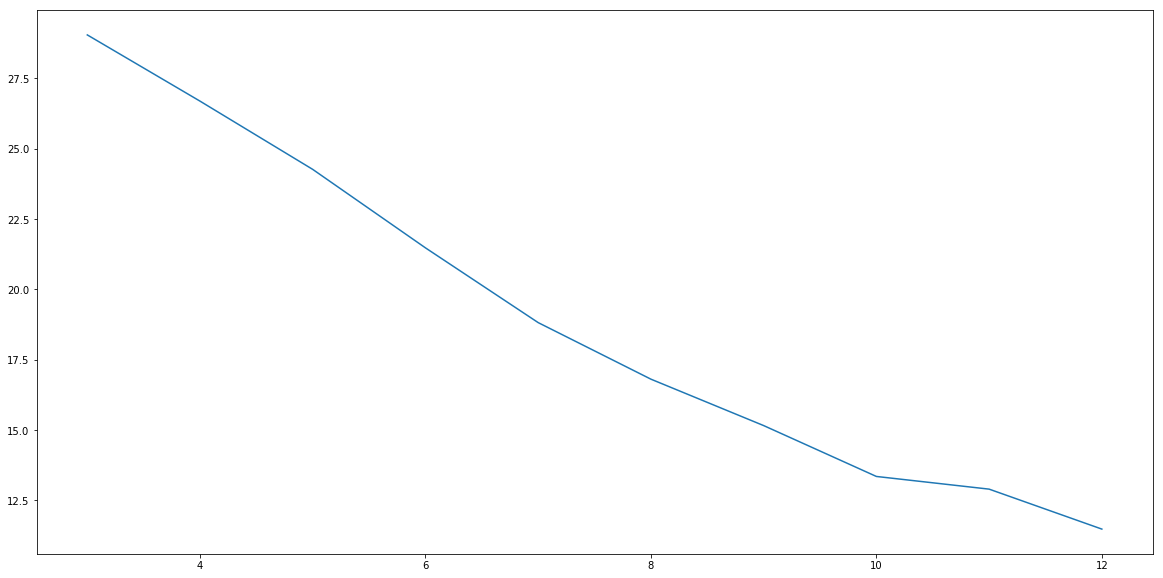

In [139]:
#Visualize result
import matplotlib.pyplot as plt

x = range(3, 13)
y = amt_result
z = pe_list

ax = plt.figure(figsize=(20, 10))

plt.plot(x, y)
plt.show()

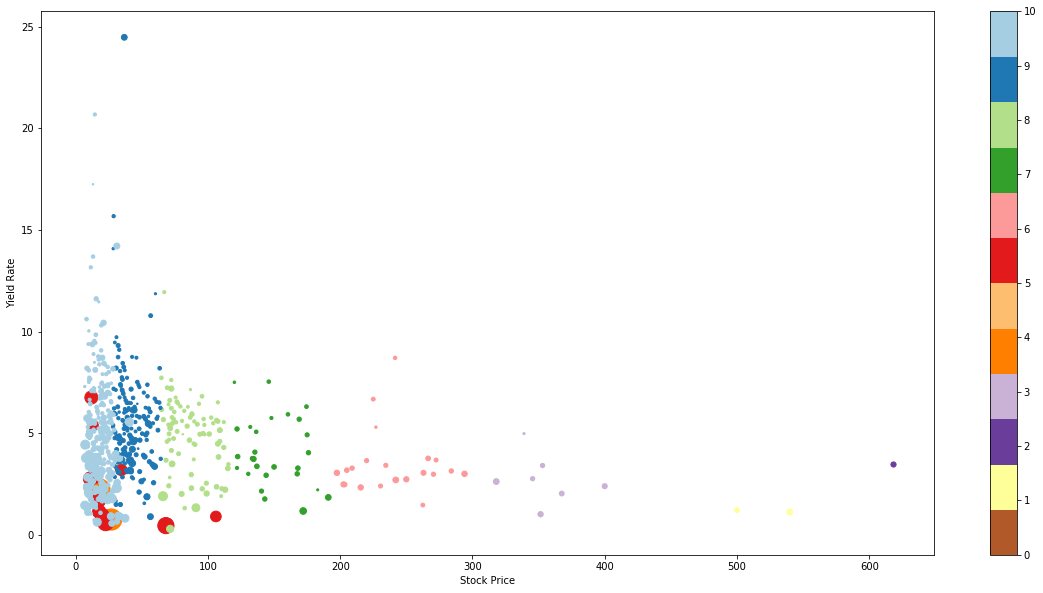

In [233]:
#Visualize the best K-means result
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

cls1 = [478, 549]
cls2 = [546]
cls3 = [65, 97, 168, 182, 185, 196, 405]
cls4 = [312, 428]
cls5 = [11, 21, 36, 131, 193, 228, 286, 369, 431, 442, 552, 618, 621]
cls6 = [66, 110, 167, 183, 198, 211, 226, 252, 263, 313, 351, 409, 416, 427, 440, 548, 553, 579, 585, 587, 597]
cls7 = [88, 92, 123, 187, 190, 213, 221, 245, 272, 311, 370, 377, 395, 406, 447, 448, 456, 458, 480, 534, 554, 556, 559, 562, 582, 599, 602]
cls8 = [9, 13, 17, 22, 23, 38, 39, 72, 87, 95, 126, 128, 136, 138, 141, 177, 184, 194, 202, 217, 220, 223, 224, 227, 229, 232, 241, 250, 253, 254, 255, 275, 291, 314, 315, 352, 354, 356, 365, 368, 384, 385, 404, 410, 411, 415, 418, 420, 422, 425, 426, 438, 443, 450, 457, 468, 470, 473, 476, 479, 482, 483, 492, 496, 515, 521, 525, 527, 528, 529, 536, 538, 539, 540, 542, 544, 555, 557, 558, 563, 568, 600, 612, 615, 616]
cls9 = [0, 1, 7, 8, 14, 15, 16, 18, 19, 20, 34, 35, 40, 42, 47, 48, 49, 67, 69, 75, 78, 79, 80, 82, 84, 85, 91, 93, 96, 109, 120, 122, 130, 134, 143, 155, 160, 163, 172, 173, 176, 178, 186, 188, 203, 204, 205, 208, 214, 218, 219, 222, 225, 230, 236, 237, 243, 246, 249, 256, 258, 259, 262, 266, 267, 271, 283, 288, 290, 292, 294, 296, 299, 302, 305, 306, 317, 321, 328, 333, 334, 355, 357, 358, 359, 361, 363, 364, 367, 373, 378, 379, 382, 383, 393, 396, 397, 400, 407, 413, 414, 424, 429, 430, 432, 434, 435, 436, 445, 449, 452, 453, 454, 455, 459, 460, 461, 462, 463, 464, 465, 466, 469, 471, 472, 474, 475, 477, 481, 488, 493, 495, 498, 501, 502, 506, 509, 513, 517, 518, 519, 522, 524, 531, 532, 537, 541, 547, 550, 551, 561, 567, 569, 571, 572, 573, 577, 578, 581, 588, 590, 591, 592, 598, 601, 603, 604, 605, 606, 607, 608, 609, 611, 613, 614, 617, 619]
cls10 = [2, 3, 4, 5, 6, 10, 12, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 37, 41, 43, 44, 45, 46, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 68, 70, 71, 73, 74, 76, 77, 81, 83, 86, 89, 90, 94, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 111, 112, 113, 114, 115, 116, 117, 118, 119, 121, 124, 125, 127, 129, 132, 133, 135, 137, 139, 140, 142, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 156, 157, 158, 159, 161, 162, 164, 165, 166, 169, 170, 171, 174, 175, 179, 180, 181, 189, 191, 192, 195, 197, 199, 200, 201, 206, 207, 209, 210, 212, 215, 216, 231, 233, 234, 235, 238, 239, 240, 242, 244, 247, 248, 251, 257, 260, 261, 264, 265, 268, 269, 270, 273, 274, 276, 277, 278, 279, 280, 281, 282, 284, 285, 287, 289, 293, 295, 297, 298, 300, 301, 303, 304, 307, 308, 309, 310, 316, 318, 319, 320, 322, 323, 324, 325, 326, 327, 329, 330, 331, 332, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 353, 360, 362, 366, 371, 372, 374, 375, 376, 380, 381, 386, 387, 388, 389, 390, 391, 392, 394, 398, 399, 401, 402, 403, 408, 412, 417, 419, 421, 423, 433, 437, 439, 441, 444, 446, 451, 467, 484, 485, 486, 487, 489, 490, 491, 494, 497, 499, 500, 503, 504, 505, 507, 508, 510, 511, 512, 514, 516, 520, 523, 526, 530, 533, 535, 543, 545, 560, 564, 565, 566, 570, 574, 575, 576, 580, 583, 584, 586, 589, 593, 594, 595, 596, 610, 620]
total_cls = [cls1, cls2, cls3, cls4, cls5, cls6, cls7, cls8, cls9, cls10]

fig = plt.figure(figsize=(20, 10))

#plt.xlim((0, 620))
#plt.ylim((0, 25))
plt.xlabel('Stock Price')
plt.ylabel('Yield Rate')
xtick = np.linspace(0, 620, 32)
ytick = np.linspace(0, 25, 26)
ctick = np.linspace(0, 10, 11)
#plt.xticks(xtick)
#plt.yticks(ytick)

cm = plt.cm.get_cmap('Paired_r')

pypc1 = plt.scatter([items[0][cls] for cls in cls1], [items[1][cls] for cls in cls1], c=[1 for n in range(len(cls1))], vmin=0, vmax =10, s=[items[2][cls] for cls in cls1], cmap=cm)
pypc2 = plt.scatter([items[0][cls] for cls in cls2], [items[1][cls] for cls in cls2], c=[2 for n in range(len(cls2))], vmin=0, vmax =10, s=[items[2][cls] for cls in cls2], cmap=cm)
pypc3 = plt.scatter([items[0][cls] for cls in cls3], [items[1][cls] for cls in cls3], c=[3 for n in range(len(cls3))], vmin=0, vmax =10, s=[items[2][cls] for cls in cls3], cmap=cm)
pypc4 = plt.scatter([items[0][cls] for cls in cls4], [items[1][cls] for cls in cls4], c=[4 for n in range(len(cls4))], vmin=0, vmax =10, s=[items[2][cls] for cls in cls4], cmap=cm)
pypc5 = plt.scatter([items[0][cls] for cls in cls5], [items[1][cls] for cls in cls5], c=[5 for n in range(len(cls5))], vmin=0, vmax =10, s=[items[2][cls] for cls in cls5], cmap=cm)
pypc6 = plt.scatter([items[0][cls] for cls in cls6], [items[1][cls] for cls in cls6], c=[6 for n in range(len(cls6))], vmin=0, vmax =10, s=[items[2][cls] for cls in cls6], cmap=cm)
pypc7 = plt.scatter([items[0][cls] for cls in cls7], [items[1][cls] for cls in cls7], c=[7 for n in range(len(cls7))], vmin=0, vmax =10, s=[items[2][cls] for cls in cls7], cmap=cm)
pypc8 = plt.scatter([items[0][cls] for cls in cls8], [items[1][cls] for cls in cls8], c=[8 for n in range(len(cls8))], vmin=0, vmax =10, s=[items[2][cls] for cls in cls8], cmap=cm)
pypc9 = plt.scatter([items[0][cls] for cls in cls9], [items[1][cls] for cls in cls9], c=[9 for n in range(len(cls9))], vmin=0, vmax =10, s=[items[2][cls] for cls in cls9], cmap=cm)
pypc10 = plt.scatter([items[0][cls] for cls in cls10], [items[1][cls] for cls in cls10], c=[10 for n in range(len(cls10))], vmin=0, vmax =10, s=[items[2][cls] for cls in cls10], cmap=cm)

colorbar = plt.colorbar(pypc10)
colorbar.set_ticks(ctick)
plt.show()


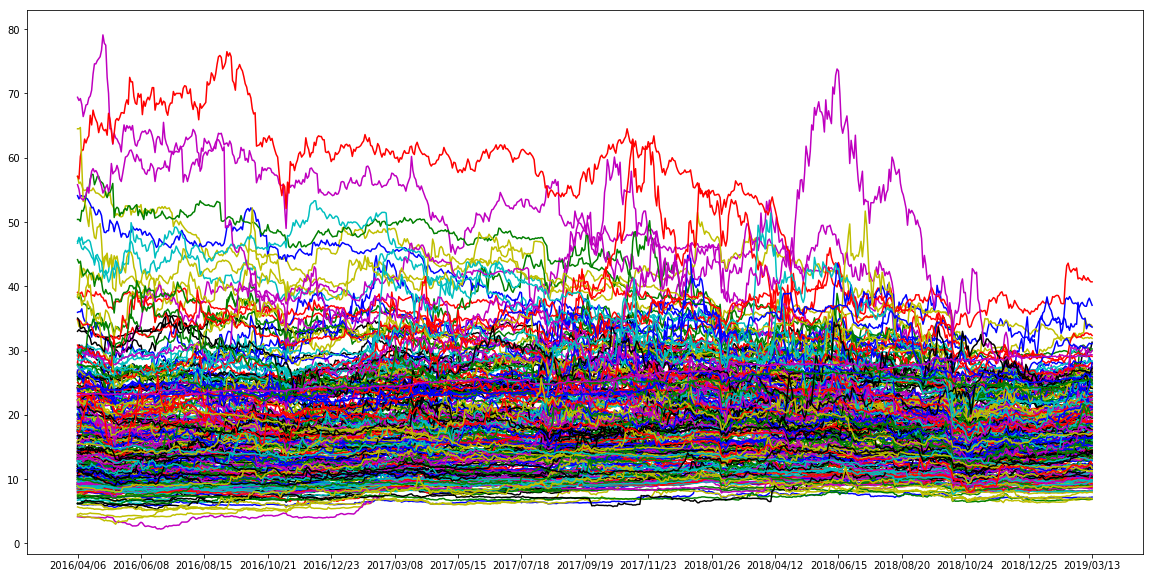

In [428]:
#Visualize stock prices and date
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

cluster = cls10

y_list = []
for idxn in range(len(cluster)):
    y_list.append(all_stock_price[cluster[idxn]][-722:-1])

xticks = 15
dates = date_list[-722:-1]
damount = len(dates)
dperiod = round(45)
x = dates

fig = plt.figure(figsize=(20, 10))
color_list = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
cn = 0
for y in y_list:
    plt.plot(x, y, color=color_list[cn%len(color_list)])
    cn += 1

ax = plt.gca()
ax.set_xticks(range(0, damount, dperiod))
ax.set_xticklabels([d for d in dates[::dperiod]])

plt.show()


In [429]:
#Show the latest price of each stock in Cluster 10
stop = open('D:/StockData/ForAnalysis/stockid.json', 'r', encoding='utf-8')
stid = json.loads(stop.read())
for cs in cls10:
    print(cs, id_index[cs], stid[id_index[cs]], '3/14 Price: %.2f  Yield: %.2f  PE: %.2f  TAIEX Cor: %.2f' %(price_list[cs], yield_list[cs], pe_list[cs], taiex_stock_correlation120[cs]))

2 1103 嘉泥 3/14 Price: 13.95  Yield: 3.58  PE: 4.93  TAIEX Cor: 0.25
3 1104 環泥 3/14 Price: 19.70  Yield: 5.58  PE: 11.26  TAIEX Cor: 0.94
4 1109 信大 3/14 Price: 13.95  Yield: 0.72  PE: 6.58  TAIEX Cor: 0.58
5 1110 東泥 3/14 Price: 16.30  Yield: 0.61  PE: 65.20  TAIEX Cor: -0.14
6 1203 味王 3/14 Price: 26.30  Yield: 4.94  PE: 14.53  TAIEX Cor: 0.05
10 1218 泰山 3/14 Price: 18.25  Yield: 2.19  PE: 20.05  TAIEX Cor: 0.61
12 1220 台榮 3/14 Price: 11.10  Yield: 3.60  PE: 23.13  TAIEX Cor: 0.25
24 1304 台聚 3/14 Price: 12.10  Yield: 2.48  PE: 14.94  TAIEX Cor: 0.85
25 1305 華夏 3/14 Price: 22.80  Yield: 8.33  PE: 7.55  TAIEX Cor: 0.72
26 1307 三芳 3/14 Price: 24.35  Yield: 6.98  PE: 27.99  TAIEX Cor: 0.89
27 1308 亞聚 3/14 Price: 14.40  Yield: 2.08  PE: 22.50  TAIEX Cor: 0.93
28 1309 台達化 3/14 Price: 10.15  Yield: 3.94  PE: 5.31  TAIEX Cor: 0.83
29 1310 台苯 3/14 Price: 24.25  Yield: 8.25  PE: 10.54  TAIEX Cor: -0.07
30 1312 國喬 3/14 Price: 23.50  Yield: 4.26  PE: 5.70  TAIEX Cor: 0.91
31 1313 聯成 3/14 Price: 13.1

In [430]:
#Show info of each stock in Cluster 10
cluster = cls10
xxxxx120, xxxxx240 = [], []
for cs in cluster:
    stidcode = int(id_index[cs])
    dl = all_stock_price[cs][-722:-1]
    x120 , x240 = float('%.2f' %np.std(all_stock_price[cs][-121:-1], ddof=1)), float('%.2f' %np.std(all_stock_price[cs][-241:-1], ddof=1))
    print(cs, stidcode, stid[id_index[cs]])
    print('120日均線:', '%.2f' %statistics.mean(all_stock_price[cs][-121:-1]), '240日均線:', '%.2f' %statistics.mean(all_stock_price[cs][-241:-1]))
    print('120日標準差:', '%.2f' %x120, '240日標準差:', '%.2f' %x240)
    print('Min:', '%.2f' %min(dl), 'Max:', '%.2f' %max(dl), 'Rate:', '%.2f' %((max(dl)/min(dl))*100))
    print('')
    xxxxx120.append(x120)
    xxxxx240.append(x240)
print('120日平均標準差:', '%.2f' %statistics.mean(xxxxx120), '240日平均標準差:', '%.2f' %statistics.mean(xxxxx240))

2 1103 嘉泥
120日均線: 13.35 240日均線: 13.33
120日標準差: 0.80 240日標準差: 1.01
Min: 8.21 Max: 15.50 Rate: 188.79

3 1104 環泥
120日均線: 19.33 240日均線: 20.12
120日標準差: 0.49 240日標準差: 1.11
Min: 18.50 Max: 27.00 Rate: 145.95

4 1109 信大
120日均線: 14.22 240日均線: 14.46
120日標準差: 0.77 240日標準差: 0.86
Min: 9.89 Max: 16.30 Rate: 164.81

5 1110 東泥
120日均線: 14.82 240日均線: 14.39
120日標準差: 1.17 240日標準差: 0.93
Min: 13.60 Max: 17.05 Rate: 125.37

6 1203 味王
120日均線: 25.67 240日均線: 25.71
120日標準差: 0.51 240日標準差: 0.43
Min: 21.30 Max: 28.00 Rate: 131.46

10 1218 泰山
120日均線: 17.35 240日均線: 17.70
120日標準差: 1.22 240日標準差: 1.16
Min: 11.95 Max: 24.25 Rate: 202.93

12 1220 台榮
120日均線: 11.39 240日均線: 11.65
120日標準差: 0.46 240日標準差: 0.49
Min: 10.10 Max: 12.50 Rate: 123.76

24 1304 台聚
120日均線: 12.42 240日均線: 13.35
120日標準差: 0.71 240日標準差: 1.10
Min: 11.50 Max: 17.20 Rate: 149.57

25 1305 華夏
120日均線: 22.41 240日均線: 26.44
120日標準差: 2.07 240日標準差: 4.43
Min: 14.15 Max: 36.30 Rate: 256.54

26 1307 三芳
120日均線: 24.20 240日均線: 27.09
120日標準差: 1.62 240日標準差: 3.36
Min: 21.85 Ma

145 1904 正隆
120日均線: 20.77 240日均線: 19.23
120日標準差: 1.71 240日標準差: 2.25
Min: 11.05 Max: 25.30 Rate: 228.96

146 1905 華紙
120日均線: 9.61 240日均線: 10.15
120日標準差: 0.39 240日標準差: 0.68
Min: 8.53 Max: 12.65 Rate: 148.30

147 1906 寶隆
120日均線: 15.88 240日均線: 19.35
120日標準差: 1.80 240日標準差: 4.16
Min: 7.80 Max: 38.50 Rate: 493.59

148 1907 永豐餘
120日均線: 11.65 240日均線: 12.05
120日標準差: 0.39 240日標準差: 0.61
Min: 8.86 Max: 14.50 Rate: 163.66

149 1909 榮成
120日均線: 16.77 240日均線: 22.94
120日標準差: 2.13 240日標準差: 7.29
Min: 13.05 Max: 51.50 Rate: 394.64

150 2002 中鋼
120日均線: 24.61 240日均線: 24.29
120日標準差: 0.56 240日標準差: 0.69
Min: 19.60 Max: 26.30 Rate: 134.18

151 2006 東和鋼鐵
120日均線: 20.75 240日均線: 22.14
120日標準差: 1.31 240日標準差: 1.84
Min: 17.95 Max: 27.65 Rate: 154.04

152 2010 春源
120日均線: 10.26 240日均線: 10.71
120日標準差: 0.29 240日標準差: 0.54
Min: 9.98 Max: 13.00 Rate: 130.26

153 2012 春雨
120日均線: 20.12 240日均線: 19.83
120日標準差: 0.59 240日標準差: 0.72
Min: 12.90 Max: 21.80 Rate: 168.99

154 2013 中鋼構
120日均線: 27.58 240日均線: 28.04
120日標準差: 2.48 240日標準差: 3.

120日均線: 22.43 240日均線: 24.08
120日標準差: 1.04 240日標準差: 1.96
Min: 21.10 Max: 35.50 Rate: 168.25

308 2701 萬企
120日均線: 12.67 240日均線: 12.82
120日標準差: 0.15 240日標準差: 0.23
Min: 12.30 Max: 14.75 Rate: 119.92

309 2704 國賓
120日均線: 22.83 240日均線: 22.75
120日標準差: 1.20 240日標準差: 0.87
Min: 21.95 Max: 27.65 Rate: 125.97

310 2706 第一店
120日均線: 14.17 240日均線: 14.55
120日標準差: 0.20 240日標準差: 0.44
Min: 13.65 Max: 18.90 Rate: 138.46

316 2801 彰銀
120日均線: 17.88 240日均線: 17.76
120日標準差: 0.39 240日標準差: 0.48
Min: 15.85 Max: 19.20 Rate: 121.14

318 2812 台中銀
120日均線: 10.39 240日均線: 10.36
120日標準差: 0.22 240日標準差: 0.18
Min: 8.81 Max: 10.90 Rate: 123.72

319 2816 旺旺保
120日均線: 19.36 240日均線: 18.81
120日標準差: 0.81 240日標準差: 1.00
Min: 11.45 Max: 22.20 Rate: 193.89

320 2820 華票
120日均線: 13.70 240日均線: 13.94
120日標準差: 0.35 240日標準差: 0.45
Min: 12.05 Max: 15.90 Rate: 131.95

322 2832 台產
120日均線: 20.02 240日均線: 20.34
120日標準差: 0.31 240日標準差: 0.45
Min: 18.35 Max: 21.30 Rate: 116.08

323 2834 臺企銀
120日均線: 10.78 240日均線: 10.18
120日標準差: 0.42 240日標準差: 0.83
Min: 

510 6141 柏承
120日均線: 16.44 240日均線: 20.79
120日標準差: 1.47 240日標準差: 5.93
Min: 7.85 Max: 39.85 Rate: 507.64

511 6153 嘉聯益
120日均線: 31.85 240日均線: 43.27
120日標準差: 5.57 240日標準差: 13.73
Min: 16.30 Max: 73.80 Rate: 452.76

512 6155 鈞寶
120日均線: 22.57 240日均線: 27.07
120日標準差: 3.54 240日標準差: 8.55
Min: 16.60 Max: 51.70 Rate: 311.45

514 6168 宏齊
120日均線: 13.12 240日均線: 15.80
120日標準差: 0.91 240日標準差: 2.95
Min: 8.94 Max: 23.45 Rate: 262.30

516 6177 達麗
120日均線: 28.22 240日均線: 31.69
120日標準差: 1.82 240日標準差: 4.04
Min: 19.25 Max: 39.00 Rate: 202.60

520 6191 精成科
120日均線: 12.94 240日均線: 13.90
120日標準差: 0.78 240日標準差: 1.53
Min: 6.96 Max: 17.45 Rate: 250.72

523 6197 佳必琪
120日均線: 26.98 240日均線: 27.29
120日標準差: 1.40 240日標準差: 1.38
Min: 24.25 Max: 41.50 Rate: 171.13

526 6205 詮欣
120日均線: 22.45 240日均線: 24.74
120日標準差: 1.29 240日標準差: 2.61
Min: 19.70 Max: 43.80 Rate: 222.34

530 6215 和椿
120日均線: 14.99 240日均線: 17.61
120日標準差: 2.08 240日標準差: 3.24
Min: 11.20 Max: 28.85 Rate: 257.59

533 6226 光鼎
120日均線: 8.86 240日均線: 9.21
120日標準差: 0.27 240日標準差: 0.

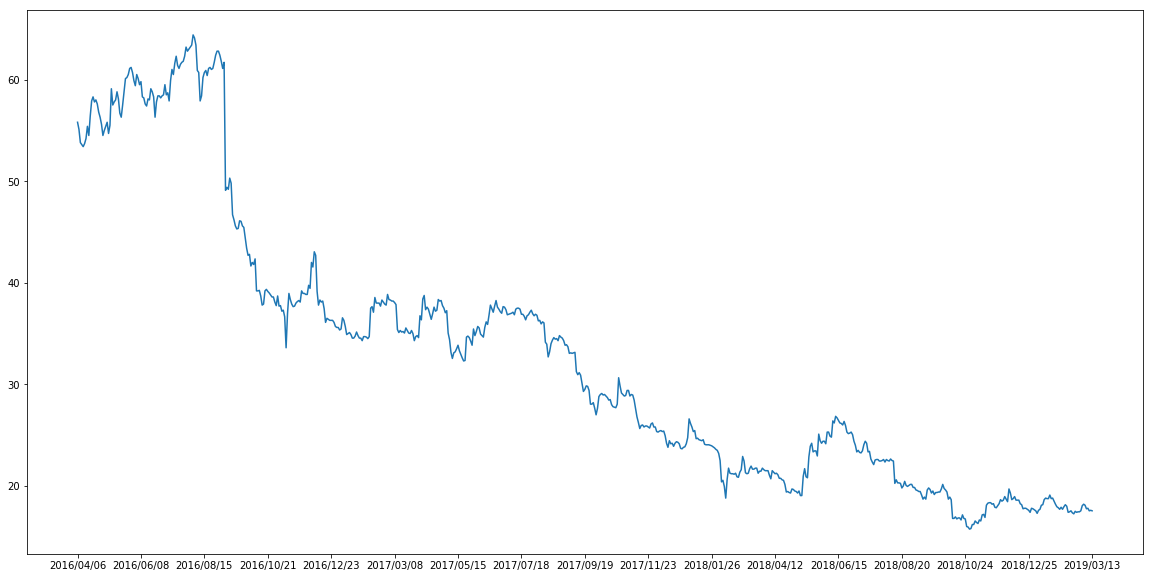

In [438]:
#Visualize Taiwan Stock Price Index and date
#yt = taiex_price
xp = 583
yt = all_stock_price[xp][-722:-1]
#xt = range(len(all_stock_price[xp]))
#xt = range(len(taiex_price))
plt.figure(figsize=(20, 10))

xticks = 15
dates = date_list[-722:-1]
damount = len(dates)
dperiod = round(45)
x = dates

ax = plt.gca()
ax.set_xticks(range(0, damount, dperiod))
ax.set_xticklabels([d for d in dates[::dperiod]])

plt.plot(x, yt)
plt.show()

[Text(0, 0, '06-01'),
 Text(0, 0, '06-10'),
 Text(0, 0, '06-19'),
 Text(0, 0, '06-28'),
 Text(0, 0, '07-07'),
 Text(0, 0, '07-16'),
 Text(0, 0, '07-25'),
 Text(0, 0, '08-03'),
 Text(0, 0, '08-12'),
 Text(0, 0, '08-21'),
 Text(0, 0, '08-30')]

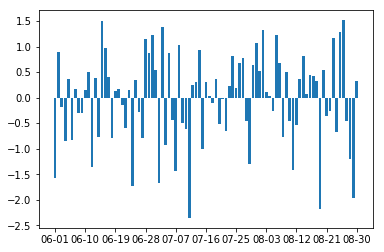

In [391]:
import numpy as np
import pandas as pd
from datetime import datetime
from matplotlib import pyplot as plt

xtick = 10
dates = list(pd.date_range(start='2017-06-01', end='2017-08-30'))
l = len(dates)
p = round(l/10)
x = [x.strftime('%Y-%m-%d') for x in dates]
y = np.random.randn(l)
plt.bar(x, +y)
ax = plt.gca()
ax.set_xticks(range(0, l, p))
ax.set_xticklabels(d.strftime('%m-%d') for d in dates[::p])
